In [19]:
import numpy as np
import matplotlib.pyplot as plt
import subprocess
from IPython.display import clear_output

def simulate (simDuration = 10, samplingStartTime = 0, debug = False):
    # Simulation parameters
    simTimeStep = 0.005  # seconds

    samplingPeriod = simTimeStep  # seconds
    numSamples = (simDuration-samplingStartTime)/samplingPeriod

    # Microfluidic channel parameters
    h_ch = 5e-6  # meters
    w_ch = 10e-6  # meters
    A_ch = h_ch * w_ch  # square meters
    u = 10e-6  # meters per second
    x_r = 1e-3  # meters
    t_d = x_r / u  # seconds

    # Molecule parameters
    D_0 = 2e-11  # square meters per second
    D = (1 + ((8.5 * u**2 * h_ch**2 * w_ch**2) / (210 * D_0**2 * (h_ch**2 + 2.4 * h_ch * w_ch + w_ch**2)))) * D_0
    K_b_m = 2e-17  # cubic meters per second
    K_u_m = 1  # per second
    K_D_m = K_u_m / K_b_m  # cubic meters

    # Receiver parameters
    N_r = 200
    l_gr = 5e-6  # meters
    w_gr = w_ch
    A_gr = l_gr * w_gr  # square meters

    # Geometry of the microfluidic channel
    l_ch = 200e-6  # meters
    vol_ch = w_ch * h_ch * l_ch  # cubic meters

    # Modulation and bitstream generation
    N_1 = 10000
    N_2 = 200
    Nt = [N_2, N_1]  # number of transmitted molecules for bit [0, 1]

    numSymbol = 10
    bitstream = np.random.randint(2, size=numSymbol)
    if debug:
        bitstream = np.tile([0, 1], 5)  # Repeat [0, 1] five times

    # Calculate ligand concentration samples
    N_m_array = np.zeros(numSymbol)
    N_m_array[bitstream == 0] = Nt[0]
    N_m_array[bitstream == 1] = Nt[1]

    c_m_peak_array = N_m_array / (A_ch * np.sqrt(4 * np.pi * D * t_d))
    cLigand_array = c_m_peak_array * 1e-18  # (1/um^3)
    numLigand_array = np.round(cLigand_array * vol_ch * 1e18).astype(int)  # Convert volume to cubic micrometers

    # Check sampling parameters
    if samplingStartTime > simDuration:
        print('Error: increase the duration of the simulation!')
    # Instead of directly comparing the remainder to 0,
    # check if it's smaller than a very small threshold
    if samplingPeriod % simTimeStep > 1:  # 1e-9 is an example threshold, adjust as needed
        print('Error: enter a new samplingPeriod that is integer multiple of simTimeStep!')

    else:
        samplingWindowLength = numSamples * samplingPeriod
        if samplingStartTime + samplingWindowLength > simDuration:
            print('Error: Sampling extends beyond the simulation duration, decrease number of samples, sampling period, sampling start time, OR increase simulation duration.')
        else:
            print(f'Starting simulations... \n Sampling Window Length = {samplingWindowLength} seconds \n Sampling Frequency = {1/samplingPeriod} Hz \n Concentration array = {bitstream.tolist()}')

            for i in range(numSymbol):
                # Prepare Smoldyn command with parameters
                command = f"smoldyn config.txt -wt --define simDuration={simDuration} " \
                        f"--define simTimeStep={simTimeStep} " \
                        f"--define numLigand={numLigand_array[i]} --define numReceptor={N_r} " \
                        f"--define diffLigand={D*1e12} " \
                        f"--define kBindLigand={K_b_m*1e18} --define kUnbindLigand={K_u_m} " \
                        f"--define w_ch={w_ch*1e6} " \
                        f"--define h_ch={h_ch*1e6} --define l_ch={l_ch*1e6} " \
                        f"--define l_rx={l_gr*1e6} --define w_rx={w_gr*1e6} " \
                        f"--define x_rx={((l_ch/2)*1e6)} --define index={i+1} " \
                        f"--define x_comp=100 --define y_comp=3 --define z_comp=5"
                        
                
                # display(command)

                # Execute command and wait for it to complete
                result = subprocess.run(command, shell=True, check=True)

                # clear_output(wait=True) 
                # print(f'Starting simulations... \n Sampling Window Length = {samplingWindowLength} seconds \n Sampling Frequency = {1/samplingPeriod} Hz')
                # print(f"Simulation {i+1}/{numSymbol} completed.")

                # Assuming these variables are defined: numSymbol, simTimeStep, samplingStartTime, simDuration

    plt.figure(figsize=(12, 6))  # Adjust size as needed

    # Initialize the starting index for the x-axis
    start_index = 0

    for i in range(numSymbol):
        outputfilename = f'configout_symbol_id_{i+1}_moleculecount.txt'
        try:
            molcount = np.loadtxt(outputfilename, delimiter=' ')
        except IOError:
            print(f"File {outputfilename} not found. Skipping symbol {i+1}.")
            continue

        filtered_data = molcount[(molcount[:, 0] >= samplingStartTime) & (molcount[:, 0] <= simDuration)]
        
        # Determine the range of indices for this segment of data
        end_index = start_index + len(filtered_data)
        data_indices = np.arange(start_index, end_index)
        
        # Plot the actual data against the data index
        plt.plot(data_indices, filtered_data[:, 3], color="#3A3B3C")

        # Perform linear regression on the data
        coeffs = np.polyfit(data_indices, filtered_data[:, 3], 1)
        # Generate y-values for the regression line based on the polynomial coefficients
        reg_line = np.polyval(coeffs, data_indices)
        # Plot the regression line
        plt.plot(data_indices, reg_line, linestyle='-', color="red")
        
        # Draw a dark grey vertical line at the end of each dataset
        plt.axvline(x=end_index-1, color='darkgrey', linestyle='-')

        stability_factor = (coeffs[0]*len(filtered_data))/(filtered_data[0][0])*100 # % of increase from the first value
        
        # Annotate the slope value near each regression line
        # Position the text at the end of the line (with a slight offset for visibility)
        plt.text(end_index-(len(filtered_data)/2), reg_line[-1]-15, f'{stability_factor:.2f}%', color="red", verticalalignment='bottom')

        # Update the starting index for the next segment of data
        start_index = end_index

    plt.title('Sampled Bound Receptors Over Index')
    plt.xlabel('Data Index')
    plt.ylabel('Bound Receptors Count')
    plt.grid(False)
    plt.show()


C:\Users\franx\AppData\Local\Temp\ipykernel_5952\687497829.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = cm.get_cmap('viridis', numSymbol)


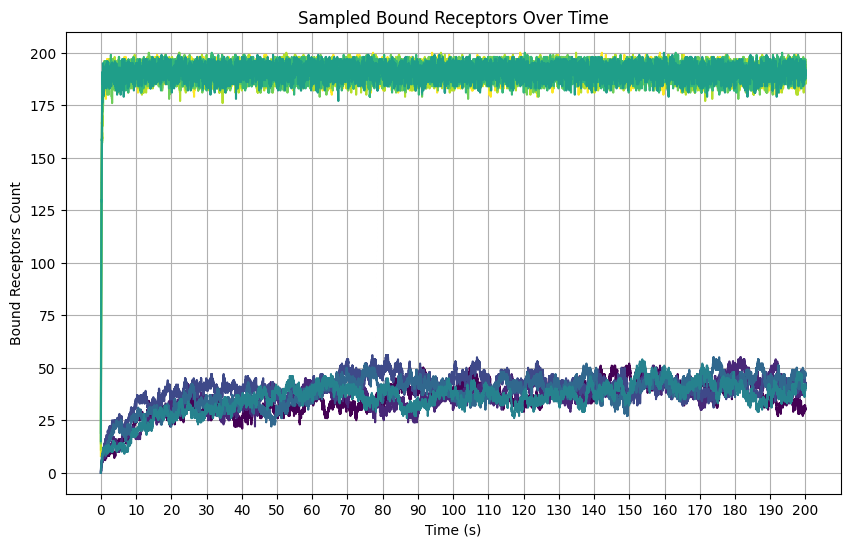

In [17]:
# plot them as replicates
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
# Assuming these variables are defined: numSymbol, samplingPeriod, simTimeStep, samplingStartTime, simDuration

simDuration = 200
samplingStartTime = 0
samplingPeriod = 0.005
simTimeStep = 0.005  # seconds
numSymbol = 10

# Correct calculation of numSamples
numSamples = int((simDuration - samplingStartTime) / samplingPeriod)

# Plotting
plt.figure(figsize=(10, 6))

# Create a colormap object based on viridis
viridis = cm.get_cmap('viridis', numSymbol)

for i in range(numSymbol):
    outputfilename = f'configout_symbol_id_{i+1}_moleculecount.txt'
    try:
        # Load data
        molcount = np.loadtxt(outputfilename, delimiter=' ')
    except IOError:
        print(f"File {outputfilename} not found. Skipping symbol {i+1}.")
        continue
    
    # Filtering data based on time range
    filtered_data = molcount[(molcount[:, 0] >= samplingStartTime) & (molcount[:, 0] <= simDuration)]
    
    # Downsampling: Calculate effective downsampling factor
    downsampling_factor = int(samplingPeriod / simTimeStep)
    if downsampling_factor < 1:
        downsampling_factor = 1
    sampled_data = filtered_data[::downsampling_factor]
    
    # Plotting
    if len(sampled_data) > 0:
        # Adjust color selection logic for even and odd symbols
        if i % 2 != 0:  # Even symbols (remember, Python indexing starts at 0, so it's inverse)
            color = viridis(1 - i/20)  # Lighter/yellowish part of the colormap
        else:  # Odd symbols
            color = viridis(0 + i/20)  # Darker part of the colormap
        plt.plot(sampled_data[:, 0], sampled_data[:, 3], label=f'Symbol {i+1}', color=color)  # Adjust column index if needed
    else:
        print(f"No data available for plotting for symbol {i+1}.")

plt.title('Sampled Bound Receptors Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Bound Receptors Count')
plt.grid(True)

x_ticks = np.arange(0, simDuration + 1, 10)  # +1 ensures the end is inclusive if it's a multiple of 5
plt.xticks(x_ticks)

# plt.legend()
plt.show()


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming these variables are defined: numSymbol, simTimeStep, samplingStartTime, simDuration

plt.figure(figsize=(12, 6))  # Adjust size as needed

# Initialize the starting index for the x-axis
start_index = 0

for i in range(numSymbol):
    outputfilename = f'configout_symbol_id_{i+1}_moleculecount.txt'
    try:
        molcount = np.loadtxt(outputfilename, delimiter=' ')
    except IOError:
        print(f"File {outputfilename} not found. Skipping symbol {i+1}.")
        continue

    filtered_data = molcount[(molcount[:, 0] >= samplingStartTime) & (molcount[:, 0] <= simDuration)]
    
    # Determine the range of indices for this segment of data
    end_index = start_index + len(filtered_data)
    data_indices = np.arange(start_index, end_index)
    
    # Plot the actual data against the data index
    plt.plot(data_indices, filtered_data[:, 3], color="#3A3B3C")

    # Perform linear regression on the data
    coeffs = np.polyfit(data_indices, filtered_data[:, 3], 1)
    # Generate y-values for the regression line based on the polynomial coefficients
    reg_line = np.polyval(coeffs, data_indices)
    # Plot the regression line
    plt.plot(data_indices, reg_line, linestyle='-', color="red")
    
    # Draw a dark grey vertical line at the end of each dataset
    plt.axvline(x=end_index-1, color='darkgrey', linestyle='-')

    stability_factor = (coeffs[0]*len(filtered_data))/(filtered_data[0][0])*100 # % of increase from the first value
    
    # Annotate the slope value near each regression line
    # Position the text at the end of the line (with a slight offset for visibility)
    plt.text(end_index-(len(filtered_data)/2), reg_line[-1]-15, f'{stability_factor:.2f}%', color="red", verticalalignment='bottom')

    # Update the starting index for the next segment of data
    start_index = end_index

plt.title('Sampled Bound Receptors Over Index')
plt.xlabel('Data Index')
plt.ylabel('Bound Receptors Count')
plt.grid(False)
plt.show()


NameError: name 'numSymbol' is not defined

<Figure size 1200x600 with 0 Axes>

Starting simulations... 
 Sampling Window Length = 10.0 seconds 
 Sampling Frequency = 200.0 Hz 
 Concentration array = [0, 1, 1, 0, 0, 0, 1, 0, 1, 1]


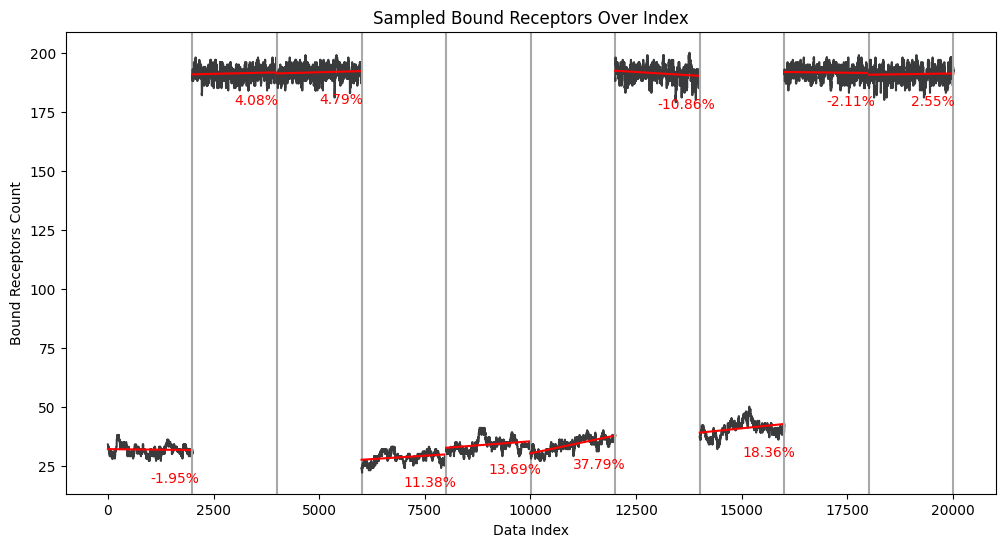

Starting simulations... 
 Sampling Window Length = 10.0 seconds 
 Sampling Frequency = 200.0 Hz 
 Concentration array = [1, 0, 0, 1, 1, 0, 1, 0, 0, 0]


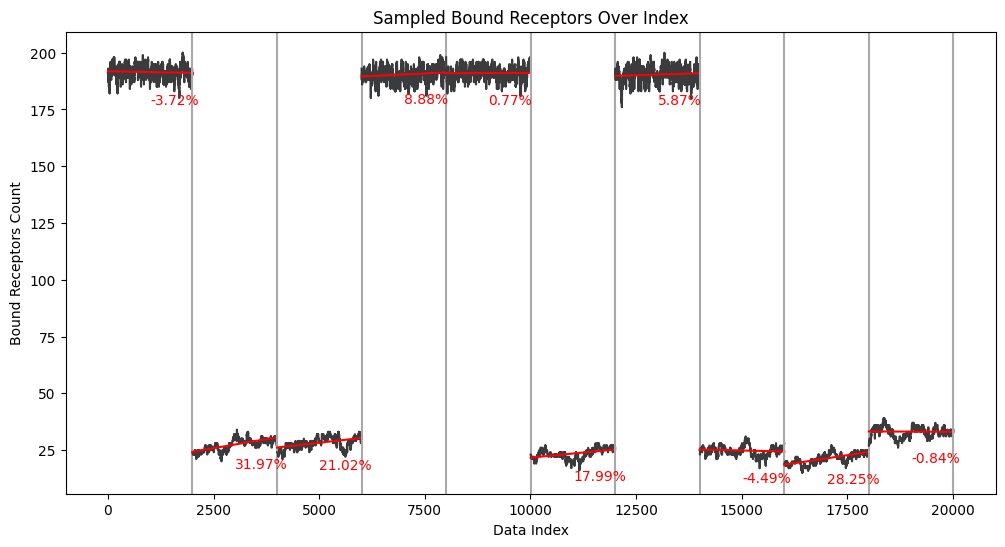

Starting simulations... 
 Sampling Window Length = 10.0 seconds 
 Sampling Frequency = 200.0 Hz 
 Concentration array = [1, 0, 0, 1, 1, 1, 1, 1, 0, 1]


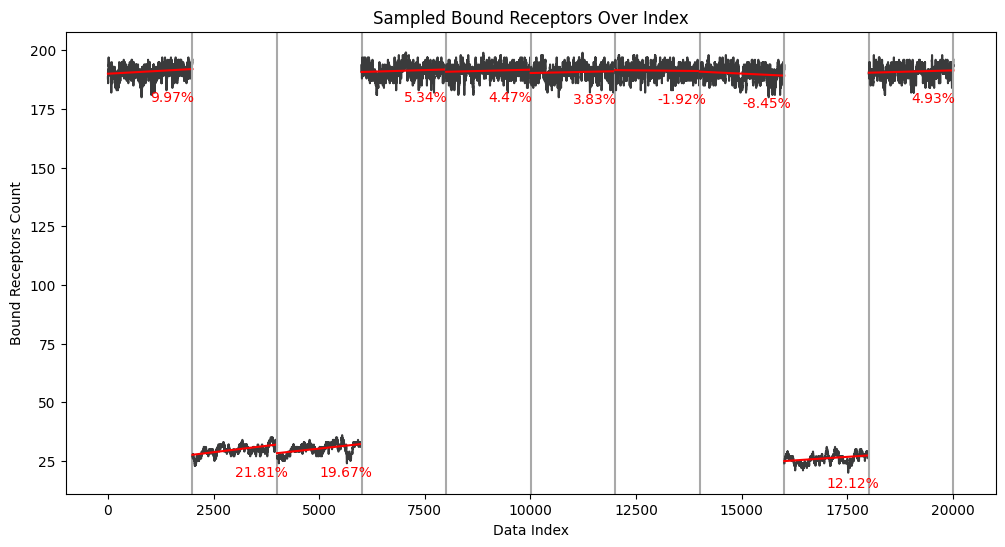

In [20]:
for i in range(3):
    simulate(simDuration = 30, samplingStartTime = 20)